In [ ]:
from google.colab import drive
drive.mount('/content/drive')

구글드라이브 안에 있는 test/pre-processing에
(1)Openpose, (2)Human Parse, (5)Parse Agnostic 한 데이터들 채워 넣음

test/pre-processing
 - openpose_img
 - openpose_json
 - image-parse
 - imge-parse-agnostic

# 1. OpenPose

**Download the Models**

- original pytorch-openpose models:
https://drive.google.com/drive/folders/1JsvI4M4ZTg98fmnCZLFM-3TeovnCRElG?usp=sharing
  - hand_pose_model.pth

- body25 models:
https://drive.google.com/drive/folders/1y1zBkk4PS8YsZgMP4zAjvaFzFoskzXEf?usp=sharing
  - pose_iter_584000.caffemodel.pt

*.pth and *.pt files are pytorch model, you could also download caffemodel file if you want to use caffe as backend.

Download the pytorch models and put them in a directory named model in the project root directory

- drive에 저장한 모델 가져오기

In [2]:
openpose_model_dir = '/content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/openpose_model'

In [3]:
#경로 이동해서 OpenPose.PyTorch/model에 pretrained model 저장
%cd OpenPose.PyTorch
!cp {openpose_model_dir}/* ./model

/content/OpenPose.PyTorch


# openpose_img

In [4]:
pwd

'/content/OpenPose.PyTorch'

In [5]:
root_dir = '/content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test'

In [6]:
import cv2
import os
import numpy as np
import sys

# # src 디렉토리의 절대 경로
# src_path = '/content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/src'

# # sys.path에 추가
# if src_path not in sys.path:
#   sys.path.append(src_path)

from src import model
from src import util
from src.body import Body
from src.hand import Hand


def load_model(use_hand=False):
    model_path = 'model/pose_iter_584000.caffemodel.pt'
    body_estimation = Body(model_path, 'body25')
    if use_hand:
        hand_estimation = Hand('model/hand_pose_model.pth')
    else:
        hand_estimation = None
    return body_estimation, hand_estimation


def inference(oriImg, test_image_path, body_estimation, hand_estimation, output_path='.'):
    candidate, subset = body_estimation(oriImg)

    # 검정 배경 생성 (원본 이미지 크기와 동일)
    canvas = np.zeros_like(oriImg)

    # Body pose 그리기
    canvas = util.draw_bodypose(canvas, candidate, subset, 'body25')

    if hand_estimation is not None:
        # Detect hand
        hands_list = util.handDetect(candidate, subset, oriImg)
        all_hand_peaks = []
        for x, y, w, is_left in hands_list:
            peaks = hand_estimation(oriImg[y:y+w, x:x+w, :])
            peaks[:, 0] = np.where(
                peaks[:, 0] == 0, peaks[:, 0], peaks[:, 0]+x)
            peaks[:, 1] = np.where(
                peaks[:, 1] == 0, peaks[:, 1], peaks[:, 1]+y)
            all_hand_peaks.append(peaks)
        canvas = util.draw_handpose(canvas, all_hand_peaks)

    # 결과 저장: 저장 이름을 요청한 형식으로 변경
    img_basename = os.path.basename(test_image_path).split('.')[0]  # 파일 이름에서 확장자 제거
    result_path = os.path.join(output_path, f'{img_basename}_rendered.png')
    cv2.imwrite(result_path, canvas)
    print(f"Saved result to: {result_path}")


if __name__ == "__main__":
    body_estimation, hand_estimation = load_model(use_hand=True)

    # 입력 및 출력 경로 설정
    input_path = f'{root_dir}/input/image'
    output_path = f'{root_dir}/pre-processing/openpose_img'
    os.makedirs(output_path, exist_ok=True)

    # 입력 디렉토리 내 모든 이미지 처리
    for test_image_name in os.listdir(input_path):
        if not test_image_name.endswith(('.jpg', '.png')):  # 이미지 파일만 처리
            continue

        test_image_path = os.path.join(input_path, test_image_name)
        oriImg = cv2.imread(test_image_path)  # B,G,R order

        print(f'Processing: {test_image_path}')
        inference(oriImg, test_image_path, body_estimation, hand_estimation, output_path)


/content/OpenPose.PyTorch/src/body.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(model_path))
/content/OpenPose.PyTo

Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_10.jpg
Saved result to: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_img/00000_10_rendered.png
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_02.jpg
Saved result to: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_img/00000_02_rendered.png
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_01.jpg
Saved result to: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_img/00000_01_rendered.png
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_03.jpg
Saved result to: /content/drive/MyDrive/Colab_Not

# openpose_json

In [8]:
import cv2
import os
import json
import numpy as np
from src import util
from src.body import Body
from src.hand import Hand


def load_model(use_hand=False):
    model_path = 'model/pose_iter_584000.caffemodel.pt'
    body_estimation = Body(model_path, 'body25')
    hand_estimation = Hand('model/hand_pose_model.pth') if use_hand else None
    return body_estimation, hand_estimation


def inference_and_save_json(image_path, body_estimation, hand_estimation, output_path):
    oriImg = cv2.imread(image_path)  # B,G,R order
    if oriImg is None:
        print(f"Error: Could not read image from path {image_path}")
        return

    # Body estimation
    candidate, subset = body_estimation(oriImg)

    # Hand estimation
    all_hand_peaks = []
    if hand_estimation is not None:
        hands_list = util.handDetect(candidate, subset, oriImg)
        for x, y, w, is_left in hands_list:
            peaks = hand_estimation(oriImg[y:y+w, x:x+w, :])
            peaks[:, 0] = np.where(peaks[:, 0] == 0, peaks[:, 0], peaks[:, 0]+x)
            peaks[:, 1] = np.where(peaks[:, 1] == 0, peaks[:, 1], peaks[:, 1]+y)
            all_hand_peaks.append(peaks)

    # Output file paths
    img_basename = os.path.basename(image_path).split('.')[0]  # ex: 00022_00
    json_filename = f"{img_basename}_keypoints.json"
    json_path = os.path.join(output_path, json_filename)

    # Prepare JSON output
    json_data = {"version": 1.3, "people": []}
    for person in subset:
        person_data = {
            "person_id": [-1],
            "pose_keypoints_2d": [],
            "face_keypoints_2d": [],
            "hand_left_keypoints_2d": [],
            "hand_right_keypoints_2d": [],
            "pose_keypoints_3d": [],
            "face_keypoints_3d": [],
            "hand_left_keypoints_3d": [],
            "hand_right_keypoints_3d": []
        }

        # Add body keypoints
        for idx in range(len(candidate)):
            if idx in person[:len(candidate)]:
                keypoint = candidate[int(idx)]
                person_data["pose_keypoints_2d"].extend([float(keypoint[0]), float(keypoint[1]), float(keypoint[2])])
            else:
                person_data["pose_keypoints_2d"].extend([0.0, 0.0, 0.0])  # Default for missing points

        # Add hand keypoints
        if len(all_hand_peaks) > 0:
            if len(all_hand_peaks) > 0:  # Left hand
                for peak in all_hand_peaks[0]:
                    person_data["hand_left_keypoints_2d"].extend(
                        [float(peak[0]), float(peak[1]), 1.0 if peak[0] > 0 else 0.0]
                    )
            else:
                person_data["hand_left_keypoints_2d"].extend([0.0] * 63)
            if len(all_hand_peaks) > 1:  # Right hand
                for peak in all_hand_peaks[1]:
                    person_data["hand_right_keypoints_2d"].extend(
                        [float(peak[0]), float(peak[1]), 1.0 if peak[0] > 0 else 0.0]
                    )
            else:
                person_data["hand_right_keypoints_2d"].extend([0.0] * 63)

        json_data["people"].append(person_data)

    # Save JSON
    os.makedirs(output_path, exist_ok=True)
    with open(json_path, "w") as json_file:
        json.dump(json_data, json_file, indent=4)
    print(f"JSON saved at {json_path}")


if __name__ == "__main__":
    # Load models
    body_estimation, hand_estimation = load_model(use_hand=True)

    # 입력 및 출력 경로 설정
    input_path = f'{root_dir}/input/image'
    output_path = f'{root_dir}/pre-processing/openpose_json'

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # 입력 디렉토리 내 모든 이미지 처리
    for image_name in os.listdir(input_path):
        if not image_name.endswith(('.jpg', '.png')):  # 이미지 파일만 처리
            continue

        image_path = os.path.join(input_path, image_name)
        print(f'Processing: {image_path}')
        inference_and_save_json(image_path, body_estimation, hand_estimation, output_path)


/content/OpenPose.PyTorch/src/body.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(model_path))
/content/OpenPose.PyTo

Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_10.jpg
JSON saved at /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_json/00000_10_keypoints.json
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_02.jpg
JSON saved at /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_json/00000_02_keypoints.json
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_01.jpg
JSON saved at /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/pre-processing/openpose_json/00000_01_keypoints.json
Processing: /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test/input/image/00000_03.jpg
JSON saved at /content/drive/MyDrive/Colab_Notebo

In [13]:
%cd ..

/content


# 2. Human Parse
- Self-Correction-Human-Parsing

In [14]:
!pip install ninja

In [15]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 722, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 722 (delta 74), reused 64 (delta 64), pack-reused 546 (from 1)
Receiving objects: 100% (722/722), 3.88 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/Self-Correction-Human-Parsing


Select dataset below

In [16]:
import gdown
dataset = 'lip'

In [17]:
if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'checkpoints/final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=fda8fd6b-3ea6-4c9d-9af4-efe0337c4e55
To: /content/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:04<00:00, 60.3MB/s]


'checkpoints/final.pth'

In [ ]:
input_data_root_dir = '/content/high-resolution-viton-zalando-dataset'

In [ ]:
pwd

'/content/Self-Correction-Human-Parsing'

In [19]:
#input 데이터 ./inputs/에 저장
!cp {root_dir}/input/image/*.jpg ./inputs/

In [20]:
!python3 simple_extractor.py --dataset 'lip' --model-restore 'checkpoints/final.pth' --input-dir 'inputs' --output-dir 'outputs'

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
/content/Self-Correction-Human-Parsing/simple_extractor.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

In [21]:
#output데이터 {root_dir}/pre-processing/image-parse/에 저장
!cp /content/Self-Correction-Human-Parsing/outputs/*.png {root_dir}/pre-processing/image-parse/


In [23]:
%cd ..

/content


# Human_Parse output check
outputs => 이미지 픽셀값이 각 특정 label값 original이랑 비교해야함

In [ ]:
import numpy as np
from PIL import Image
ori_parse_img_dir = '/content/high-resolution-viton-zalando-dataset/test/image-parse-v3/00008_00.png'
parse_img_dir = '/content/Self-Correction-Human-Parsing/outputs/00008_00.png'

# load parsing image
#parse_name = im_name.replace('.jpg', '.png')
ori_im_parse = Image.open(ori_parse_img_dir)
im_parse = Image.open(parse_img_dir)
label_array_ori = np.array(ori_im_parse)
#print(label_array.shape)
label_array = np.array(im_parse)
print(label_array_ori.shape)
print(label_array.shape)


(1024, 768)
(1024, 768)


In [ ]:
import numpy as np
from PIL import Image

ori_parse_img_dir = '/content/high-resolution-viton-zalando-dataset/test/image-parse-v3/00008_00.png'
parse_img_dir = '/content/Self-Correction-Human-Parsing/outputs/00008_00.png'

# 파싱 이미지 로드
ori_im_parse = Image.open(ori_parse_img_dir)
im_parse = Image.open(parse_img_dir)
label_array_ori = np.array(ori_im_parse)
label_array = np.array(im_parse)

# 배열의 모양 비교
print("label_array_ori의 모양:", label_array_ori.shape)
print("label_array의 모양:", label_array.shape)

# 차이점 찾기
diff = np.where(label_array_ori != label_array)

# 차이점 개수 출력
num_diff = len(diff[0])
print("차이점 개수:", num_diff)

# 차이점의 인덱스와 값 출력
if num_diff > 0:
  print("차이점의 인덱스:", diff)
  print("label_array_ori의 값:", label_array_ori[diff])
  print("label_array의 값:", label_array[diff])
else:
  print("차이점을 찾을 수 없습니다.")

# 차이점 시각화 (선택 사항)
diff_image = np.zeros_like(label_array_ori, dtype=np.uint8)
diff_image[diff] = 255
diff_image = Image.fromarray(diff_image)
# 출력을 보려면 코드를 실행하세요.
diff_image.show()

label_array_ori의 모양: (1024, 768)
label_array의 모양: (1024, 768)
차이점 개수: 49540
차이점의 인덱스: (array([   0,    0,    1, ..., 1023, 1023, 1023]), array([266, 396, 265, ..., 565, 566, 567]))
label_array_ori의 값: [0 0 0 ... 0 0 0]
label_array의 값: [2 2 2 ... 9 9 9]


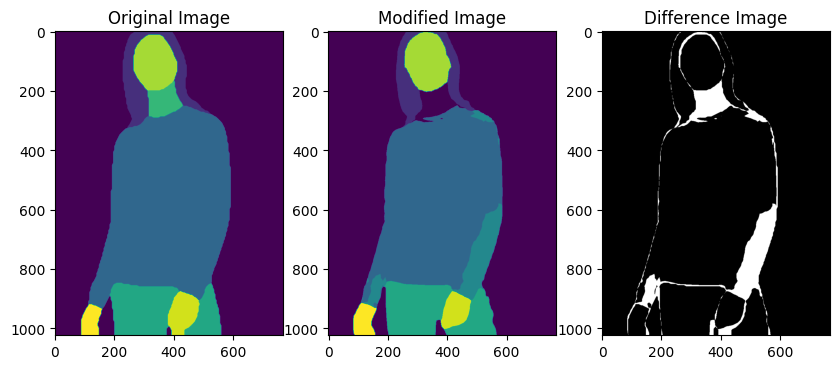

In [ ]:
import matplotlib.pyplot as plt
# 차이점 시각화
diff_image = np.zeros_like(label_array_ori, dtype=np.uint8)
diff_image[diff] = 255  # 차이점을 흰색으로 표시

# matplotlib을 사용하여 이미지 표시
plt.figure(figsize=(10, 5))  # 이미지 크기 설정

plt.subplot(1, 3, 1)  # 1행 3열 중 첫 번째 위치
plt.imshow(label_array_ori)  # 원본 이미지 표시
plt.title('Original Image')  # 제목 설정

plt.subplot(1, 3, 2)  # 1행 3열 중 두 번째 위치
plt.imshow(label_array)  # 수정된 이미지 표시
plt.title('Modified Image')  # 제목 설정

plt.subplot(1, 3, 3)  # 1행 3열 중 세 번째 위치
plt.imshow(diff_image, cmap='gray')  # 차이점 이미지 표시 (회색조)
plt.title('Difference Image')  # 제목 설정

plt.show()  # 이미지 출력

# 5. Parse Agnostic
- input : images, openopse_json, image-parse-v3

(1) OpenPose의 pose keypoints 데이터를 활용하여 사람의 관절 위치 정보를 읽어옵니다.

(2) 사람의 몸 부위가 포함된 segmentation 이미지 데이터를 읽어옵니다.

(3)특정 부위를 가리고 남은 부위를 출력하는 **"agnostic image"**를 생성합니다.
  
  (여기서 "agnostic image"란 가려진 특정 부위를 제외한 나머지 부위만 남긴 이미지)

(4) 결과 이미지를 저장합니다.

In [24]:
# image와 cloth 이미지들 pre-processing 폴더에 저장
# root_dir = /content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test
# {root_dir}/input/image => {root_dir}/pre-processing/image
# {root_dir}/input/cloth => {root_dir}/pre-processing/cloth

!cp {root_dir}/input/image/*.jpg {root_dir}/pre-processing/image/
!cp {root_dir}/input/cloth/*.jpg {root_dir}/pre-processing/cloth/


In [25]:
!pip install Pillow tqdm

(2) Run

In [26]:
root_dir

'/content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation/test'

In [29]:
%cd drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation

/content/drive/MyDrive/Colab_Notebooks/likelion_AIEngineer/Clothing_Segmentation


In [31]:
import json
from os import path as osp
import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

#입력으로 분할된 이미지(im_parse)와 포즈 데이터(pose_data)를 받아, 지정된 부위를 마스킹한 결과를 반환
#im_parse => image_parse/*.png
#pose_data => openpose_json/*.json
def get_im_parse_agnostic(im_parse, pose_data, w=768, h=1024):
    label_array = np.array(im_parse)
    parse_upper = ((label_array == 5).astype(np.float32) +
                    (label_array == 6).astype(np.float32) +
                    (label_array == 7).astype(np.float32)) #상체(5, 6, 7 레이블)와 목(10 레이블)을 분할 이미지에서 찾아 마스킹할 영역으로 지정
    parse_neck = (label_array == 10).astype(np.float32)

    r = 10
    agnostic = im_parse.copy() #마스킹된 이미지

    # mask arms
    # OpenPose에서 추출한 팔 관절 좌표를 사용해 팔 부위를 마스킹
    for parse_id, pose_ids in [(14, [2, 5, 6, 7]), (15, [5, 2, 3, 4])]:
        mask_arm = Image.new('L', (w, h), 'black')
        mask_arm_draw = ImageDraw.Draw(mask_arm)
        i_prev = pose_ids[0]
        for i in pose_ids[1:]:
            if (pose_data[i_prev, 0] == 0.0 and pose_data[i_prev, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue
            mask_arm_draw.line([tuple(pose_data[j]) for j in [i_prev, i]], 'white', width=r*10)
            pointx, pointy = pose_data[i]
            radius = r*4 if i == pose_ids[-1] else r*15
            mask_arm_draw.ellipse((pointx-radius, pointy-radius, pointx+radius, pointy+radius), 'white', 'white')
            i_prev = i
        parse_arm = (np.array(mask_arm) / 255) * (label_array == parse_id).astype(np.float32)
        agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

    # mask torso & neck
    agnostic.paste(0, None, Image.fromarray(np.uint8(parse_upper * 255), 'L'))
    agnostic.paste(0, None, Image.fromarray(np.uint8(parse_neck * 255), 'L'))

    return agnostic


if __name__ =="__main__":
    data_path = './test/pre-processing'
    output_path = './test/pre-processing/image-parse-agnostic' #'./test/parse'

    #os.makedirs(output_path, exist_ok=True)

    for im_name in tqdm(os.listdir(osp.join(data_path, 'image'))):

        # load pose image
        pose_name = im_name.replace('.jpg', '_keypoints.json')

        try:
            with open(osp.join(data_path, 'openpose_json', pose_name), 'r') as f:
                pose_label = json.load(f)
                pose_data = pose_label['people'][0]['pose_keypoints_2d']
                pose_data = np.array(pose_data)
                pose_data = pose_data.reshape((-1, 3))[:, :2]
        except IndexError:
            print(pose_name)
            continue

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join(data_path, 'image-parse', parse_name))

        agnostic = get_im_parse_agnostic(im_parse, pose_data)

        agnostic.save(osp.join(output_path, parse_name))

100%|██████████| 7/7 [00:00<00:00, 10.52it/s]


# Parse_Agnostic output check

In [ ]:
import numpy as np
from PIL import Image

im_ori = Image.open('./test/image-parse-v3/06868_00.png')
im = Image.open('./test/parse/06868_00.png')
print(np.unique(np.array(im_ori)))
print(np.unique(np.array(im)))

[ 0  2  5  9 10 13 14 15]
[ 0  2  9 13 14 15]


10 => Neck?

The output may look like

[ 0  2  5  9 10 13 14 15]
[ 0  2  9 13 14 15]
=> 원래 이런듯

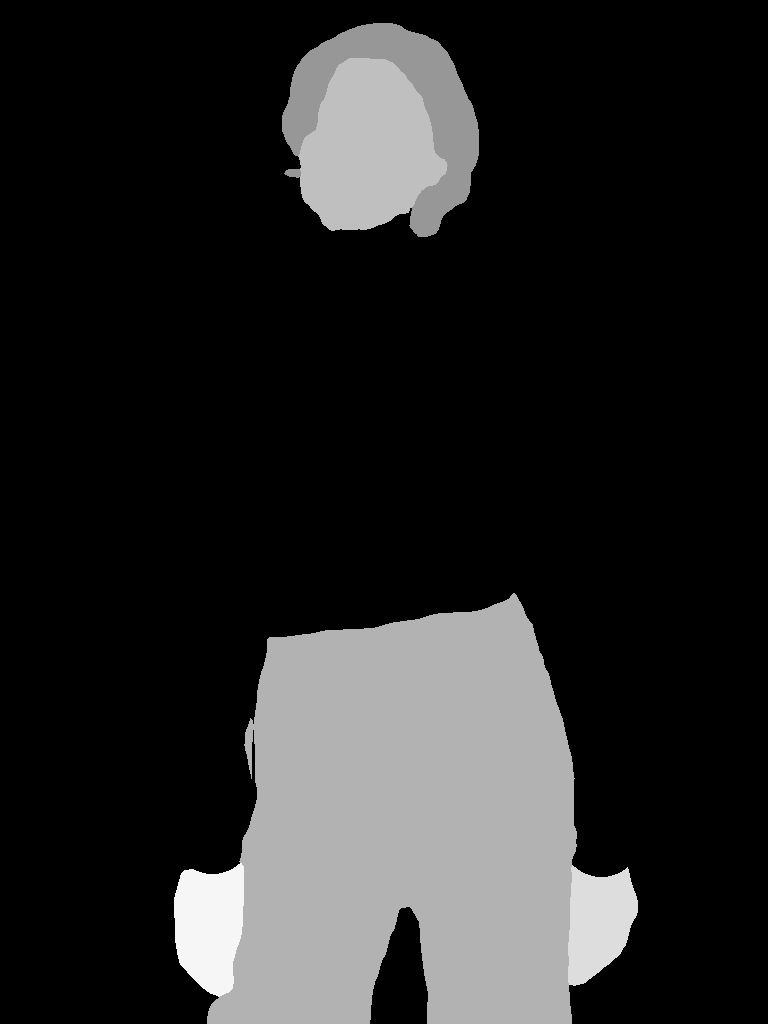

In [ ]:
np_im = np.array(im)
np_im[np_im==2] = 151
np_im[np_im==9] = 178
np_im[np_im==13] = 191
np_im[np_im==14] = 221
np_im[np_im==15] = 246
Image.fromarray(np_im)